# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [3]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


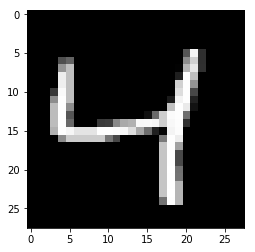

In [5]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **deconvolutional** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but it reverse. A stride in the input layer results in a larger stride in the deconvolutional layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a deconvolutional layer. Deconvolution is often called "transpose convolution" which is what you'll find with the TensorFlow API, with [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, deconvolutional layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor).

In [6]:
learning_rate = 0.001
# size = mnist.train.images.shape[1]
inputs_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(2,2),strides=(2,2),padding='valid')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same',activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='valid')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same')
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='valid')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_images(encoded, (7,7))

# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_images(conv4, (14,14))

# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_images(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3),padding='same', activation=tf.nn.relu)
# print(conv6.shape)
# Now 28x28x16

logits = tf.layers.dense(conv6, 1, activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded =tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [7]:
sess = tf.Session()

In [8]:
epochs = 10
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/10... Training loss: 0.6914
Epoch: 1/10... Training loss: 0.6885
Epoch: 1/10... Training loss: 0.6851
Epoch: 1/10... Training loss: 0.6813
Epoch: 1/10... Training loss: 0.6768
Epoch: 1/10... Training loss: 0.6711
Epoch: 1/10... Training loss: 0.6648
Epoch: 1/10... Training loss: 0.6576
Epoch: 1/10... Training loss: 0.6484
Epoch: 1/10... Training loss: 0.6400
Epoch: 1/10... Training loss: 0.6303
Epoch: 1/10... Training loss: 0.6216
Epoch: 1/10... Training loss: 0.6094
Epoch: 1/10... Training loss: 0.5974
Epoch: 1/10... Training loss: 0.5845
Epoch: 1/10... Training loss: 0.5728
Epoch: 1/10... Training loss: 0.5608
Epoch: 1/10... Training loss: 0.5523
Epoch: 1/10... Training loss: 0.5426
Epoch: 1/10... Training loss: 0.5409
Epoch: 1/10... Training loss: 0.5367
Epoch: 1/10... Training loss: 0.5314
Epoch: 1/10... Training loss: 0.5248
Epoch: 1/10... Training loss: 0.5164
Epoch: 1/10... Training loss: 0.5103
Epoch: 1/10... Training loss: 0.5081
Epoch: 1/10... Training loss: 0.4919
E

Epoch: 1/10... Training loss: 0.1213
Epoch: 1/10... Training loss: 0.1236
Epoch: 1/10... Training loss: 0.1191
Epoch: 1/10... Training loss: 0.1183
Epoch: 1/10... Training loss: 0.1200
Epoch: 1/10... Training loss: 0.1192
Epoch: 1/10... Training loss: 0.1194
Epoch: 1/10... Training loss: 0.1155
Epoch: 1/10... Training loss: 0.1189
Epoch: 1/10... Training loss: 0.1198
Epoch: 1/10... Training loss: 0.1167
Epoch: 1/10... Training loss: 0.1199
Epoch: 1/10... Training loss: 0.1174
Epoch: 1/10... Training loss: 0.1138
Epoch: 1/10... Training loss: 0.1180
Epoch: 1/10... Training loss: 0.1144
Epoch: 1/10... Training loss: 0.1125
Epoch: 1/10... Training loss: 0.1155
Epoch: 1/10... Training loss: 0.1142
Epoch: 1/10... Training loss: 0.1098
Epoch: 1/10... Training loss: 0.1131
Epoch: 1/10... Training loss: 0.1156
Epoch: 1/10... Training loss: 0.1131
Epoch: 1/10... Training loss: 0.1087
Epoch: 1/10... Training loss: 0.1104
Epoch: 1/10... Training loss: 0.1081
Epoch: 1/10... Training loss: 0.1096
E

Epoch: 2/10... Training loss: 0.0923
Epoch: 2/10... Training loss: 0.0945
Epoch: 2/10... Training loss: 0.0931
Epoch: 2/10... Training loss: 0.0907
Epoch: 2/10... Training loss: 0.0923
Epoch: 2/10... Training loss: 0.0940
Epoch: 2/10... Training loss: 0.0945
Epoch: 2/10... Training loss: 0.0979
Epoch: 2/10... Training loss: 0.0935
Epoch: 2/10... Training loss: 0.0946
Epoch: 2/10... Training loss: 0.0898
Epoch: 2/10... Training loss: 0.0938
Epoch: 2/10... Training loss: 0.0949
Epoch: 2/10... Training loss: 0.0928
Epoch: 2/10... Training loss: 0.0939
Epoch: 2/10... Training loss: 0.0928
Epoch: 2/10... Training loss: 0.0936
Epoch: 2/10... Training loss: 0.0937
Epoch: 2/10... Training loss: 0.0943
Epoch: 2/10... Training loss: 0.0928
Epoch: 2/10... Training loss: 0.0934
Epoch: 2/10... Training loss: 0.0949
Epoch: 2/10... Training loss: 0.0955
Epoch: 2/10... Training loss: 0.0927
Epoch: 2/10... Training loss: 0.0951
Epoch: 2/10... Training loss: 0.0877
Epoch: 2/10... Training loss: 0.0934
E

Epoch: 3/10... Training loss: 0.0883
Epoch: 3/10... Training loss: 0.0890
Epoch: 3/10... Training loss: 0.0884
Epoch: 3/10... Training loss: 0.0901
Epoch: 3/10... Training loss: 0.0888
Epoch: 3/10... Training loss: 0.0896
Epoch: 3/10... Training loss: 0.0899
Epoch: 3/10... Training loss: 0.0901
Epoch: 3/10... Training loss: 0.0878
Epoch: 3/10... Training loss: 0.0880
Epoch: 3/10... Training loss: 0.0884
Epoch: 3/10... Training loss: 0.0888
Epoch: 3/10... Training loss: 0.0898
Epoch: 3/10... Training loss: 0.0888
Epoch: 3/10... Training loss: 0.0914
Epoch: 3/10... Training loss: 0.0869
Epoch: 3/10... Training loss: 0.0886
Epoch: 3/10... Training loss: 0.0877
Epoch: 3/10... Training loss: 0.0871
Epoch: 3/10... Training loss: 0.0906
Epoch: 3/10... Training loss: 0.0884
Epoch: 3/10... Training loss: 0.0901
Epoch: 3/10... Training loss: 0.0895
Epoch: 3/10... Training loss: 0.0881
Epoch: 3/10... Training loss: 0.0893
Epoch: 3/10... Training loss: 0.0864
Epoch: 3/10... Training loss: 0.0880
E

Epoch: 3/10... Training loss: 0.0872
Epoch: 3/10... Training loss: 0.0865
Epoch: 3/10... Training loss: 0.0854
Epoch: 3/10... Training loss: 0.0817
Epoch: 3/10... Training loss: 0.0848
Epoch: 3/10... Training loss: 0.0851
Epoch: 3/10... Training loss: 0.0813
Epoch: 3/10... Training loss: 0.0844
Epoch: 3/10... Training loss: 0.0838
Epoch: 3/10... Training loss: 0.0863
Epoch: 3/10... Training loss: 0.0865
Epoch: 4/10... Training loss: 0.0841
Epoch: 4/10... Training loss: 0.0848
Epoch: 4/10... Training loss: 0.0835
Epoch: 4/10... Training loss: 0.0856
Epoch: 4/10... Training loss: 0.0865
Epoch: 4/10... Training loss: 0.0835
Epoch: 4/10... Training loss: 0.0850
Epoch: 4/10... Training loss: 0.0867
Epoch: 4/10... Training loss: 0.0850
Epoch: 4/10... Training loss: 0.0868
Epoch: 4/10... Training loss: 0.0864
Epoch: 4/10... Training loss: 0.0859
Epoch: 4/10... Training loss: 0.0859
Epoch: 4/10... Training loss: 0.0867
Epoch: 4/10... Training loss: 0.0830
Epoch: 4/10... Training loss: 0.0864
E

Epoch: 4/10... Training loss: 0.0842
Epoch: 4/10... Training loss: 0.0851
Epoch: 4/10... Training loss: 0.0795
Epoch: 4/10... Training loss: 0.0866
Epoch: 4/10... Training loss: 0.0828
Epoch: 4/10... Training loss: 0.0810
Epoch: 4/10... Training loss: 0.0828
Epoch: 4/10... Training loss: 0.0858
Epoch: 4/10... Training loss: 0.0833
Epoch: 4/10... Training loss: 0.0819
Epoch: 4/10... Training loss: 0.0814
Epoch: 4/10... Training loss: 0.0824
Epoch: 4/10... Training loss: 0.0841
Epoch: 4/10... Training loss: 0.0867
Epoch: 4/10... Training loss: 0.0847
Epoch: 4/10... Training loss: 0.0853
Epoch: 4/10... Training loss: 0.0834
Epoch: 4/10... Training loss: 0.0829
Epoch: 4/10... Training loss: 0.0822
Epoch: 4/10... Training loss: 0.0826
Epoch: 4/10... Training loss: 0.0832
Epoch: 4/10... Training loss: 0.0837
Epoch: 4/10... Training loss: 0.0827
Epoch: 4/10... Training loss: 0.0834
Epoch: 4/10... Training loss: 0.0860
Epoch: 4/10... Training loss: 0.0856
Epoch: 4/10... Training loss: 0.0827
E

Epoch: 5/10... Training loss: 0.0803
Epoch: 5/10... Training loss: 0.0812
Epoch: 5/10... Training loss: 0.0845
Epoch: 5/10... Training loss: 0.0827
Epoch: 5/10... Training loss: 0.0802
Epoch: 5/10... Training loss: 0.0801
Epoch: 5/10... Training loss: 0.0847
Epoch: 5/10... Training loss: 0.0798
Epoch: 5/10... Training loss: 0.0813
Epoch: 5/10... Training loss: 0.0854
Epoch: 5/10... Training loss: 0.0840
Epoch: 5/10... Training loss: 0.0832
Epoch: 5/10... Training loss: 0.0827
Epoch: 5/10... Training loss: 0.0827
Epoch: 5/10... Training loss: 0.0826
Epoch: 5/10... Training loss: 0.0789
Epoch: 5/10... Training loss: 0.0832
Epoch: 5/10... Training loss: 0.0811
Epoch: 5/10... Training loss: 0.0814
Epoch: 5/10... Training loss: 0.0812
Epoch: 5/10... Training loss: 0.0828
Epoch: 5/10... Training loss: 0.0834
Epoch: 5/10... Training loss: 0.0828
Epoch: 5/10... Training loss: 0.0795
Epoch: 5/10... Training loss: 0.0822
Epoch: 5/10... Training loss: 0.0806
Epoch: 5/10... Training loss: 0.0822
E

Epoch: 6/10... Training loss: 0.0784
Epoch: 6/10... Training loss: 0.0814
Epoch: 6/10... Training loss: 0.0799
Epoch: 6/10... Training loss: 0.0809
Epoch: 6/10... Training loss: 0.0821
Epoch: 6/10... Training loss: 0.0800
Epoch: 6/10... Training loss: 0.0786
Epoch: 6/10... Training loss: 0.0816
Epoch: 6/10... Training loss: 0.0847
Epoch: 6/10... Training loss: 0.0822
Epoch: 6/10... Training loss: 0.0814
Epoch: 6/10... Training loss: 0.0800
Epoch: 6/10... Training loss: 0.0780
Epoch: 6/10... Training loss: 0.0795
Epoch: 6/10... Training loss: 0.0817
Epoch: 6/10... Training loss: 0.0770
Epoch: 6/10... Training loss: 0.0796
Epoch: 6/10... Training loss: 0.0830
Epoch: 6/10... Training loss: 0.0807
Epoch: 6/10... Training loss: 0.0810
Epoch: 6/10... Training loss: 0.0805
Epoch: 6/10... Training loss: 0.0787
Epoch: 6/10... Training loss: 0.0836
Epoch: 6/10... Training loss: 0.0817
Epoch: 6/10... Training loss: 0.0827
Epoch: 6/10... Training loss: 0.0815
Epoch: 6/10... Training loss: 0.0822
E

Epoch: 6/10... Training loss: 0.0804
Epoch: 6/10... Training loss: 0.0789
Epoch: 6/10... Training loss: 0.0779
Epoch: 6/10... Training loss: 0.0808
Epoch: 6/10... Training loss: 0.0823
Epoch: 6/10... Training loss: 0.0772
Epoch: 6/10... Training loss: 0.0782
Epoch: 6/10... Training loss: 0.0790
Epoch: 6/10... Training loss: 0.0789
Epoch: 6/10... Training loss: 0.0767
Epoch: 6/10... Training loss: 0.0807
Epoch: 6/10... Training loss: 0.0804
Epoch: 6/10... Training loss: 0.0776
Epoch: 6/10... Training loss: 0.0805
Epoch: 6/10... Training loss: 0.0794
Epoch: 6/10... Training loss: 0.0816
Epoch: 6/10... Training loss: 0.0804
Epoch: 6/10... Training loss: 0.0799
Epoch: 6/10... Training loss: 0.0804
Epoch: 6/10... Training loss: 0.0818
Epoch: 6/10... Training loss: 0.0758
Epoch: 6/10... Training loss: 0.0771
Epoch: 6/10... Training loss: 0.0808
Epoch: 7/10... Training loss: 0.0773
Epoch: 7/10... Training loss: 0.0772
Epoch: 7/10... Training loss: 0.0826
Epoch: 7/10... Training loss: 0.0810
E

Epoch: 7/10... Training loss: 0.0818
Epoch: 7/10... Training loss: 0.0804
Epoch: 7/10... Training loss: 0.0800
Epoch: 7/10... Training loss: 0.0786
Epoch: 7/10... Training loss: 0.0784
Epoch: 7/10... Training loss: 0.0793
Epoch: 7/10... Training loss: 0.0777
Epoch: 7/10... Training loss: 0.0807
Epoch: 7/10... Training loss: 0.0778
Epoch: 7/10... Training loss: 0.0799
Epoch: 7/10... Training loss: 0.0782
Epoch: 7/10... Training loss: 0.0775
Epoch: 7/10... Training loss: 0.0767
Epoch: 7/10... Training loss: 0.0782
Epoch: 7/10... Training loss: 0.0779
Epoch: 7/10... Training loss: 0.0786
Epoch: 7/10... Training loss: 0.0777
Epoch: 7/10... Training loss: 0.0800
Epoch: 7/10... Training loss: 0.0794
Epoch: 7/10... Training loss: 0.0786
Epoch: 7/10... Training loss: 0.0789
Epoch: 7/10... Training loss: 0.0768
Epoch: 7/10... Training loss: 0.0777
Epoch: 7/10... Training loss: 0.0804
Epoch: 7/10... Training loss: 0.0774
Epoch: 7/10... Training loss: 0.0777
Epoch: 7/10... Training loss: 0.0785
E

Epoch: 8/10... Training loss: 0.0786
Epoch: 8/10... Training loss: 0.0813
Epoch: 8/10... Training loss: 0.0791
Epoch: 8/10... Training loss: 0.0784
Epoch: 8/10... Training loss: 0.0779
Epoch: 8/10... Training loss: 0.0772
Epoch: 8/10... Training loss: 0.0795
Epoch: 8/10... Training loss: 0.0792
Epoch: 8/10... Training loss: 0.0799
Epoch: 8/10... Training loss: 0.0777
Epoch: 8/10... Training loss: 0.0763
Epoch: 8/10... Training loss: 0.0778
Epoch: 8/10... Training loss: 0.0805
Epoch: 8/10... Training loss: 0.0790
Epoch: 8/10... Training loss: 0.0776
Epoch: 8/10... Training loss: 0.0791
Epoch: 8/10... Training loss: 0.0767
Epoch: 8/10... Training loss: 0.0774
Epoch: 8/10... Training loss: 0.0783
Epoch: 8/10... Training loss: 0.0778
Epoch: 8/10... Training loss: 0.0764
Epoch: 8/10... Training loss: 0.0758
Epoch: 8/10... Training loss: 0.0765
Epoch: 8/10... Training loss: 0.0773
Epoch: 8/10... Training loss: 0.0759
Epoch: 8/10... Training loss: 0.0776
Epoch: 8/10... Training loss: 0.0785
E

Epoch: 9/10... Training loss: 0.0777
Epoch: 9/10... Training loss: 0.0778
Epoch: 9/10... Training loss: 0.0789
Epoch: 9/10... Training loss: 0.0781
Epoch: 9/10... Training loss: 0.0754
Epoch: 9/10... Training loss: 0.0780
Epoch: 9/10... Training loss: 0.0774
Epoch: 9/10... Training loss: 0.0783
Epoch: 9/10... Training loss: 0.0796
Epoch: 9/10... Training loss: 0.0764
Epoch: 9/10... Training loss: 0.0753
Epoch: 9/10... Training loss: 0.0759
Epoch: 9/10... Training loss: 0.0793
Epoch: 9/10... Training loss: 0.0768
Epoch: 9/10... Training loss: 0.0748
Epoch: 9/10... Training loss: 0.0779
Epoch: 9/10... Training loss: 0.0798
Epoch: 9/10... Training loss: 0.0784
Epoch: 9/10... Training loss: 0.0777
Epoch: 9/10... Training loss: 0.0794
Epoch: 9/10... Training loss: 0.0772
Epoch: 9/10... Training loss: 0.0773
Epoch: 9/10... Training loss: 0.0771
Epoch: 9/10... Training loss: 0.0790
Epoch: 9/10... Training loss: 0.0779
Epoch: 9/10... Training loss: 0.0774
Epoch: 9/10... Training loss: 0.0788
E

Epoch: 9/10... Training loss: 0.0768
Epoch: 9/10... Training loss: 0.0781
Epoch: 9/10... Training loss: 0.0779
Epoch: 9/10... Training loss: 0.0781
Epoch: 9/10... Training loss: 0.0791
Epoch: 9/10... Training loss: 0.0734
Epoch: 9/10... Training loss: 0.0789
Epoch: 9/10... Training loss: 0.0766
Epoch: 9/10... Training loss: 0.0774
Epoch: 9/10... Training loss: 0.0774
Epoch: 9/10... Training loss: 0.0757
Epoch: 9/10... Training loss: 0.0782
Epoch: 9/10... Training loss: 0.0760
Epoch: 9/10... Training loss: 0.0774
Epoch: 9/10... Training loss: 0.0782
Epoch: 9/10... Training loss: 0.0771
Epoch: 9/10... Training loss: 0.0746
Epoch: 9/10... Training loss: 0.0781
Epoch: 9/10... Training loss: 0.0776
Epoch: 9/10... Training loss: 0.0767
Epoch: 9/10... Training loss: 0.0770
Epoch: 9/10... Training loss: 0.0793
Epoch: 9/10... Training loss: 0.0765
Epoch: 9/10... Training loss: 0.0778
Epoch: 9/10... Training loss: 0.0775
Epoch: 9/10... Training loss: 0.0770
Epoch: 9/10... Training loss: 0.0781
E

Epoch: 10/10... Training loss: 0.0766
Epoch: 10/10... Training loss: 0.0759
Epoch: 10/10... Training loss: 0.0776
Epoch: 10/10... Training loss: 0.0734
Epoch: 10/10... Training loss: 0.0784
Epoch: 10/10... Training loss: 0.0761
Epoch: 10/10... Training loss: 0.0762
Epoch: 10/10... Training loss: 0.0767
Epoch: 10/10... Training loss: 0.0749
Epoch: 10/10... Training loss: 0.0758
Epoch: 10/10... Training loss: 0.0758
Epoch: 10/10... Training loss: 0.0767
Epoch: 10/10... Training loss: 0.0781
Epoch: 10/10... Training loss: 0.0777
Epoch: 10/10... Training loss: 0.0779
Epoch: 10/10... Training loss: 0.0742
Epoch: 10/10... Training loss: 0.0769
Epoch: 10/10... Training loss: 0.0760
Epoch: 10/10... Training loss: 0.0767
Epoch: 10/10... Training loss: 0.0756
Epoch: 10/10... Training loss: 0.0776
Epoch: 10/10... Training loss: 0.0764
Epoch: 10/10... Training loss: 0.0777
Epoch: 10/10... Training loss: 0.0758
Epoch: 10/10... Training loss: 0.0754
Epoch: 10/10... Training loss: 0.0754
Epoch: 10/10

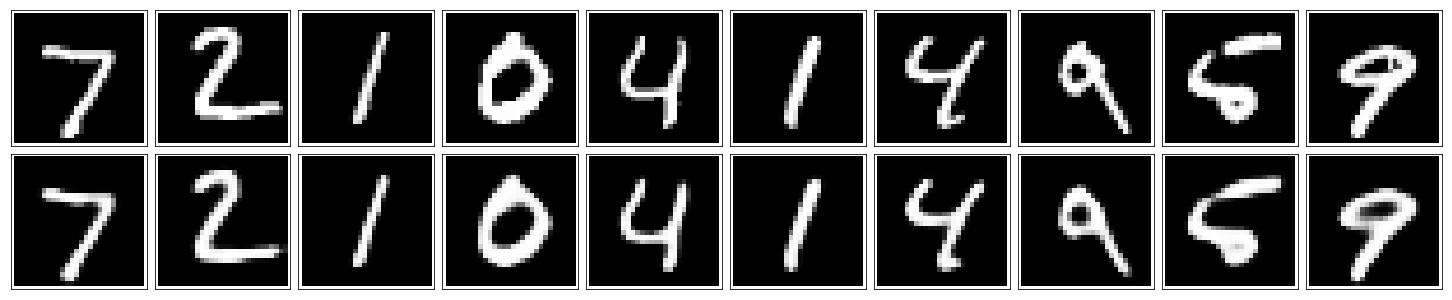

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [10]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [11]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same',activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2),padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same',activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2),padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same',activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
print(encoded.shape)
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same',activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same',activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same',activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.dense(conv6, 1, activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

(?, 4, 4, 16)


In [12]:
sess = tf.Session()

In [14]:
epochs = 10
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/10... Training loss: 0.6904
Epoch: 1/10... Training loss: 0.6756
Epoch: 1/10... Training loss: 0.6535
Epoch: 1/10... Training loss: 0.6215
Epoch: 1/10... Training loss: 0.5855
Epoch: 1/10... Training loss: 0.5374
Epoch: 1/10... Training loss: 0.5089
Epoch: 1/10... Training loss: 0.5016
Epoch: 1/10... Training loss: 0.5240
Epoch: 1/10... Training loss: 0.5253
Epoch: 1/10... Training loss: 0.5101
Epoch: 1/10... Training loss: 0.4917
Epoch: 1/10... Training loss: 0.4833
Epoch: 1/10... Training loss: 0.4738
Epoch: 1/10... Training loss: 0.4672
Epoch: 1/10... Training loss: 0.4619
Epoch: 1/10... Training loss: 0.4532
Epoch: 1/10... Training loss: 0.4523
Epoch: 1/10... Training loss: 0.4359
Epoch: 1/10... Training loss: 0.4390
Epoch: 1/10... Training loss: 0.4296
Epoch: 1/10... Training loss: 0.4112
Epoch: 1/10... Training loss: 0.3907
Epoch: 1/10... Training loss: 0.3902
Epoch: 1/10... Training loss: 0.3788
Epoch: 1/10... Training loss: 0.3676
Epoch: 1/10... Training loss: 0.3570
E

Epoch: 1/10... Training loss: 0.1796
Epoch: 1/10... Training loss: 0.1790
Epoch: 1/10... Training loss: 0.1754
Epoch: 1/10... Training loss: 0.1779
Epoch: 1/10... Training loss: 0.1790
Epoch: 1/10... Training loss: 0.1786
Epoch: 1/10... Training loss: 0.1756
Epoch: 1/10... Training loss: 0.1749
Epoch: 1/10... Training loss: 0.1757
Epoch: 1/10... Training loss: 0.1753
Epoch: 1/10... Training loss: 0.1758
Epoch: 1/10... Training loss: 0.1761
Epoch: 1/10... Training loss: 0.1749
Epoch: 1/10... Training loss: 0.1817
Epoch: 1/10... Training loss: 0.1781
Epoch: 1/10... Training loss: 0.1722
Epoch: 1/10... Training loss: 0.1771
Epoch: 1/10... Training loss: 0.1784
Epoch: 1/10... Training loss: 0.1750
Epoch: 1/10... Training loss: 0.1775
Epoch: 1/10... Training loss: 0.1760
Epoch: 1/10... Training loss: 0.1759
Epoch: 1/10... Training loss: 0.1709
Epoch: 1/10... Training loss: 0.1707
Epoch: 1/10... Training loss: 0.1744
Epoch: 1/10... Training loss: 0.1778
Epoch: 1/10... Training loss: 0.1722
E

Epoch: 2/10... Training loss: 0.1563
Epoch: 2/10... Training loss: 0.1523
Epoch: 2/10... Training loss: 0.1584
Epoch: 2/10... Training loss: 0.1543
Epoch: 2/10... Training loss: 0.1554
Epoch: 2/10... Training loss: 0.1620
Epoch: 2/10... Training loss: 0.1546
Epoch: 2/10... Training loss: 0.1567
Epoch: 2/10... Training loss: 0.1556
Epoch: 2/10... Training loss: 0.1572
Epoch: 2/10... Training loss: 0.1568
Epoch: 2/10... Training loss: 0.1547
Epoch: 2/10... Training loss: 0.1577
Epoch: 2/10... Training loss: 0.1552
Epoch: 2/10... Training loss: 0.1552
Epoch: 2/10... Training loss: 0.1558
Epoch: 2/10... Training loss: 0.1533
Epoch: 2/10... Training loss: 0.1512
Epoch: 2/10... Training loss: 0.1577
Epoch: 2/10... Training loss: 0.1548
Epoch: 2/10... Training loss: 0.1579
Epoch: 2/10... Training loss: 0.1572
Epoch: 2/10... Training loss: 0.1501
Epoch: 2/10... Training loss: 0.1554
Epoch: 2/10... Training loss: 0.1501
Epoch: 2/10... Training loss: 0.1598
Epoch: 2/10... Training loss: 0.1577
E

Epoch: 3/10... Training loss: 0.1424
Epoch: 3/10... Training loss: 0.1419
Epoch: 3/10... Training loss: 0.1462
Epoch: 3/10... Training loss: 0.1431
Epoch: 3/10... Training loss: 0.1442
Epoch: 3/10... Training loss: 0.1407
Epoch: 3/10... Training loss: 0.1480
Epoch: 3/10... Training loss: 0.1460
Epoch: 3/10... Training loss: 0.1426
Epoch: 3/10... Training loss: 0.1509
Epoch: 3/10... Training loss: 0.1479
Epoch: 3/10... Training loss: 0.1378
Epoch: 3/10... Training loss: 0.1493
Epoch: 3/10... Training loss: 0.1448
Epoch: 3/10... Training loss: 0.1479
Epoch: 3/10... Training loss: 0.1408
Epoch: 3/10... Training loss: 0.1436
Epoch: 3/10... Training loss: 0.1446
Epoch: 3/10... Training loss: 0.1451
Epoch: 3/10... Training loss: 0.1454
Epoch: 3/10... Training loss: 0.1433
Epoch: 3/10... Training loss: 0.1460
Epoch: 3/10... Training loss: 0.1509
Epoch: 3/10... Training loss: 0.1481
Epoch: 3/10... Training loss: 0.1409
Epoch: 3/10... Training loss: 0.1410
Epoch: 3/10... Training loss: 0.1421
E

Epoch: 3/10... Training loss: 0.1415
Epoch: 3/10... Training loss: 0.1358
Epoch: 3/10... Training loss: 0.1417
Epoch: 3/10... Training loss: 0.1365
Epoch: 3/10... Training loss: 0.1333
Epoch: 3/10... Training loss: 0.1404
Epoch: 3/10... Training loss: 0.1374
Epoch: 3/10... Training loss: 0.1434
Epoch: 3/10... Training loss: 0.1347
Epoch: 3/10... Training loss: 0.1436
Epoch: 3/10... Training loss: 0.1343
Epoch: 3/10... Training loss: 0.1429
Epoch: 4/10... Training loss: 0.1390
Epoch: 4/10... Training loss: 0.1401
Epoch: 4/10... Training loss: 0.1375
Epoch: 4/10... Training loss: 0.1372
Epoch: 4/10... Training loss: 0.1410
Epoch: 4/10... Training loss: 0.1335
Epoch: 4/10... Training loss: 0.1351
Epoch: 4/10... Training loss: 0.1398
Epoch: 4/10... Training loss: 0.1393
Epoch: 4/10... Training loss: 0.1443
Epoch: 4/10... Training loss: 0.1432
Epoch: 4/10... Training loss: 0.1377
Epoch: 4/10... Training loss: 0.1354
Epoch: 4/10... Training loss: 0.1425
Epoch: 4/10... Training loss: 0.1370
E

Epoch: 4/10... Training loss: 0.1353
Epoch: 4/10... Training loss: 0.1374
Epoch: 4/10... Training loss: 0.1333
Epoch: 4/10... Training loss: 0.1345
Epoch: 4/10... Training loss: 0.1367
Epoch: 4/10... Training loss: 0.1324
Epoch: 4/10... Training loss: 0.1338
Epoch: 4/10... Training loss: 0.1329
Epoch: 4/10... Training loss: 0.1325
Epoch: 4/10... Training loss: 0.1337
Epoch: 4/10... Training loss: 0.1343
Epoch: 4/10... Training loss: 0.1301
Epoch: 4/10... Training loss: 0.1373
Epoch: 4/10... Training loss: 0.1364
Epoch: 4/10... Training loss: 0.1326
Epoch: 4/10... Training loss: 0.1298
Epoch: 4/10... Training loss: 0.1329
Epoch: 4/10... Training loss: 0.1344
Epoch: 4/10... Training loss: 0.1357
Epoch: 4/10... Training loss: 0.1335
Epoch: 4/10... Training loss: 0.1322
Epoch: 4/10... Training loss: 0.1366
Epoch: 4/10... Training loss: 0.1318
Epoch: 4/10... Training loss: 0.1271
Epoch: 4/10... Training loss: 0.1352
Epoch: 4/10... Training loss: 0.1330
Epoch: 4/10... Training loss: 0.1314
E

Epoch: 5/10... Training loss: 0.1288
Epoch: 5/10... Training loss: 0.1306
Epoch: 5/10... Training loss: 0.1293
Epoch: 5/10... Training loss: 0.1273
Epoch: 5/10... Training loss: 0.1287
Epoch: 5/10... Training loss: 0.1349
Epoch: 5/10... Training loss: 0.1307
Epoch: 5/10... Training loss: 0.1266
Epoch: 5/10... Training loss: 0.1312
Epoch: 5/10... Training loss: 0.1292
Epoch: 5/10... Training loss: 0.1350
Epoch: 5/10... Training loss: 0.1318
Epoch: 5/10... Training loss: 0.1337
Epoch: 5/10... Training loss: 0.1290
Epoch: 5/10... Training loss: 0.1324
Epoch: 5/10... Training loss: 0.1290
Epoch: 5/10... Training loss: 0.1284
Epoch: 5/10... Training loss: 0.1310
Epoch: 5/10... Training loss: 0.1238
Epoch: 5/10... Training loss: 0.1302
Epoch: 5/10... Training loss: 0.1334
Epoch: 5/10... Training loss: 0.1334
Epoch: 5/10... Training loss: 0.1289
Epoch: 5/10... Training loss: 0.1284
Epoch: 5/10... Training loss: 0.1289
Epoch: 5/10... Training loss: 0.1252
Epoch: 5/10... Training loss: 0.1292
E

Epoch: 6/10... Training loss: 0.1307
Epoch: 6/10... Training loss: 0.1312
Epoch: 6/10... Training loss: 0.1261
Epoch: 6/10... Training loss: 0.1234
Epoch: 6/10... Training loss: 0.1279
Epoch: 6/10... Training loss: 0.1260
Epoch: 6/10... Training loss: 0.1246
Epoch: 6/10... Training loss: 0.1304
Epoch: 6/10... Training loss: 0.1269
Epoch: 6/10... Training loss: 0.1305
Epoch: 6/10... Training loss: 0.1293
Epoch: 6/10... Training loss: 0.1269
Epoch: 6/10... Training loss: 0.1297
Epoch: 6/10... Training loss: 0.1253
Epoch: 6/10... Training loss: 0.1267
Epoch: 6/10... Training loss: 0.1261
Epoch: 6/10... Training loss: 0.1253
Epoch: 6/10... Training loss: 0.1253
Epoch: 6/10... Training loss: 0.1206
Epoch: 6/10... Training loss: 0.1224
Epoch: 6/10... Training loss: 0.1288
Epoch: 6/10... Training loss: 0.1250
Epoch: 6/10... Training loss: 0.1271
Epoch: 6/10... Training loss: 0.1232
Epoch: 6/10... Training loss: 0.1278
Epoch: 6/10... Training loss: 0.1252
Epoch: 6/10... Training loss: 0.1295
E

Epoch: 6/10... Training loss: 0.1242
Epoch: 6/10... Training loss: 0.1250
Epoch: 6/10... Training loss: 0.1293
Epoch: 6/10... Training loss: 0.1286
Epoch: 6/10... Training loss: 0.1236
Epoch: 6/10... Training loss: 0.1298
Epoch: 6/10... Training loss: 0.1265
Epoch: 6/10... Training loss: 0.1257
Epoch: 6/10... Training loss: 0.1263
Epoch: 6/10... Training loss: 0.1253
Epoch: 6/10... Training loss: 0.1217
Epoch: 6/10... Training loss: 0.1255
Epoch: 6/10... Training loss: 0.1260
Epoch: 6/10... Training loss: 0.1244
Epoch: 6/10... Training loss: 0.1258
Epoch: 6/10... Training loss: 0.1234
Epoch: 6/10... Training loss: 0.1259
Epoch: 6/10... Training loss: 0.1238
Epoch: 6/10... Training loss: 0.1231
Epoch: 6/10... Training loss: 0.1206
Epoch: 6/10... Training loss: 0.1268
Epoch: 6/10... Training loss: 0.1234
Epoch: 6/10... Training loss: 0.1236
Epoch: 6/10... Training loss: 0.1209
Epoch: 7/10... Training loss: 0.1214
Epoch: 7/10... Training loss: 0.1231
Epoch: 7/10... Training loss: 0.1230
E

Epoch: 7/10... Training loss: 0.1177
Epoch: 7/10... Training loss: 0.1250
Epoch: 7/10... Training loss: 0.1230
Epoch: 7/10... Training loss: 0.1213
Epoch: 7/10... Training loss: 0.1246
Epoch: 7/10... Training loss: 0.1224
Epoch: 7/10... Training loss: 0.1181
Epoch: 7/10... Training loss: 0.1214
Epoch: 7/10... Training loss: 0.1247
Epoch: 7/10... Training loss: 0.1243
Epoch: 7/10... Training loss: 0.1171
Epoch: 7/10... Training loss: 0.1230
Epoch: 7/10... Training loss: 0.1239
Epoch: 7/10... Training loss: 0.1263
Epoch: 7/10... Training loss: 0.1270
Epoch: 7/10... Training loss: 0.1270
Epoch: 7/10... Training loss: 0.1244
Epoch: 7/10... Training loss: 0.1213
Epoch: 7/10... Training loss: 0.1236
Epoch: 7/10... Training loss: 0.1225
Epoch: 7/10... Training loss: 0.1247
Epoch: 7/10... Training loss: 0.1214
Epoch: 7/10... Training loss: 0.1197
Epoch: 7/10... Training loss: 0.1215
Epoch: 7/10... Training loss: 0.1226
Epoch: 7/10... Training loss: 0.1264
Epoch: 7/10... Training loss: 0.1232
E

Epoch: 8/10... Training loss: 0.1238
Epoch: 8/10... Training loss: 0.1212
Epoch: 8/10... Training loss: 0.1207
Epoch: 8/10... Training loss: 0.1231
Epoch: 8/10... Training loss: 0.1216
Epoch: 8/10... Training loss: 0.1241
Epoch: 8/10... Training loss: 0.1182
Epoch: 8/10... Training loss: 0.1216
Epoch: 8/10... Training loss: 0.1218
Epoch: 8/10... Training loss: 0.1213
Epoch: 8/10... Training loss: 0.1239
Epoch: 8/10... Training loss: 0.1195
Epoch: 8/10... Training loss: 0.1244
Epoch: 8/10... Training loss: 0.1181
Epoch: 8/10... Training loss: 0.1222
Epoch: 8/10... Training loss: 0.1220
Epoch: 8/10... Training loss: 0.1208
Epoch: 8/10... Training loss: 0.1211
Epoch: 8/10... Training loss: 0.1248
Epoch: 8/10... Training loss: 0.1210
Epoch: 8/10... Training loss: 0.1244
Epoch: 8/10... Training loss: 0.1200
Epoch: 8/10... Training loss: 0.1220
Epoch: 8/10... Training loss: 0.1236
Epoch: 8/10... Training loss: 0.1201
Epoch: 8/10... Training loss: 0.1222
Epoch: 8/10... Training loss: 0.1165
E

Epoch: 9/10... Training loss: 0.1181
Epoch: 9/10... Training loss: 0.1185
Epoch: 9/10... Training loss: 0.1201
Epoch: 9/10... Training loss: 0.1193
Epoch: 9/10... Training loss: 0.1123
Epoch: 9/10... Training loss: 0.1187
Epoch: 9/10... Training loss: 0.1194
Epoch: 9/10... Training loss: 0.1161
Epoch: 9/10... Training loss: 0.1238
Epoch: 9/10... Training loss: 0.1172
Epoch: 9/10... Training loss: 0.1196
Epoch: 9/10... Training loss: 0.1211
Epoch: 9/10... Training loss: 0.1185
Epoch: 9/10... Training loss: 0.1170
Epoch: 9/10... Training loss: 0.1212
Epoch: 9/10... Training loss: 0.1166
Epoch: 9/10... Training loss: 0.1215
Epoch: 9/10... Training loss: 0.1204
Epoch: 9/10... Training loss: 0.1174
Epoch: 9/10... Training loss: 0.1178
Epoch: 9/10... Training loss: 0.1219
Epoch: 9/10... Training loss: 0.1227
Epoch: 9/10... Training loss: 0.1213
Epoch: 9/10... Training loss: 0.1194
Epoch: 9/10... Training loss: 0.1233
Epoch: 9/10... Training loss: 0.1172
Epoch: 9/10... Training loss: 0.1193
E

Epoch: 9/10... Training loss: 0.1190
Epoch: 9/10... Training loss: 0.1173
Epoch: 9/10... Training loss: 0.1172
Epoch: 9/10... Training loss: 0.1197
Epoch: 9/10... Training loss: 0.1169
Epoch: 9/10... Training loss: 0.1206
Epoch: 9/10... Training loss: 0.1180
Epoch: 9/10... Training loss: 0.1200
Epoch: 9/10... Training loss: 0.1204
Epoch: 9/10... Training loss: 0.1197
Epoch: 9/10... Training loss: 0.1222
Epoch: 9/10... Training loss: 0.1206
Epoch: 9/10... Training loss: 0.1156
Epoch: 9/10... Training loss: 0.1143
Epoch: 9/10... Training loss: 0.1159
Epoch: 9/10... Training loss: 0.1184
Epoch: 9/10... Training loss: 0.1202
Epoch: 9/10... Training loss: 0.1199
Epoch: 9/10... Training loss: 0.1207
Epoch: 9/10... Training loss: 0.1161
Epoch: 9/10... Training loss: 0.1190
Epoch: 9/10... Training loss: 0.1160
Epoch: 9/10... Training loss: 0.1167
Epoch: 9/10... Training loss: 0.1200
Epoch: 9/10... Training loss: 0.1131
Epoch: 9/10... Training loss: 0.1171
Epoch: 9/10... Training loss: 0.1218
E

Epoch: 10/10... Training loss: 0.1145
Epoch: 10/10... Training loss: 0.1163
Epoch: 10/10... Training loss: 0.1182
Epoch: 10/10... Training loss: 0.1210
Epoch: 10/10... Training loss: 0.1159
Epoch: 10/10... Training loss: 0.1179
Epoch: 10/10... Training loss: 0.1178
Epoch: 10/10... Training loss: 0.1143
Epoch: 10/10... Training loss: 0.1186
Epoch: 10/10... Training loss: 0.1225
Epoch: 10/10... Training loss: 0.1164
Epoch: 10/10... Training loss: 0.1154
Epoch: 10/10... Training loss: 0.1175
Epoch: 10/10... Training loss: 0.1196
Epoch: 10/10... Training loss: 0.1162
Epoch: 10/10... Training loss: 0.1185
Epoch: 10/10... Training loss: 0.1181
Epoch: 10/10... Training loss: 0.1173
Epoch: 10/10... Training loss: 0.1153
Epoch: 10/10... Training loss: 0.1148
Epoch: 10/10... Training loss: 0.1190
Epoch: 10/10... Training loss: 0.1162
Epoch: 10/10... Training loss: 0.1189
Epoch: 10/10... Training loss: 0.1172
Epoch: 10/10... Training loss: 0.1149
Epoch: 10/10... Training loss: 0.1160
Epoch: 10/10

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

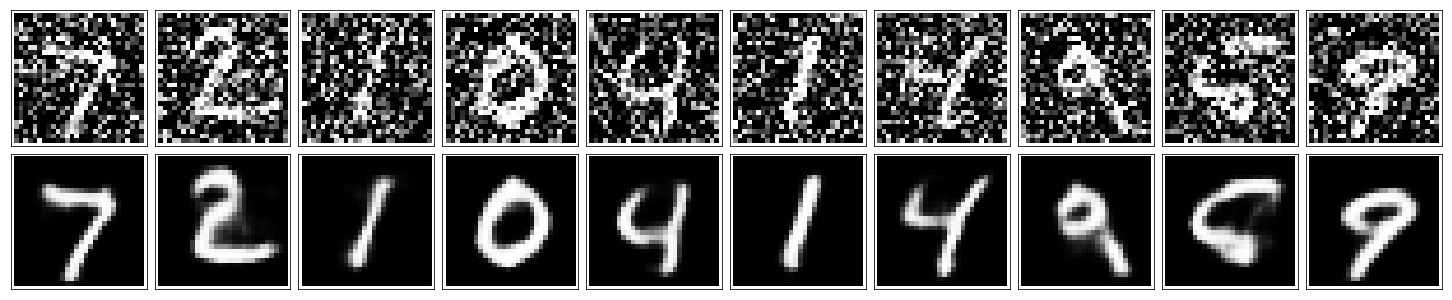

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)